In [1]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- 1. Configuración "Supervivencia" (1.5 GB) ---
os.environ['SPARK_HOME'] = "/home/hadoop/spark"
sys.path.insert(0, "/home/hadoop/spark/python")
sys.path.insert(0, "/home/hadoop/spark/python/lib/py4j-0.10.9.7-src.zip") 
sys.path.insert(0, "/home/hadoop/spark/python/lib/pyspark.zip")

spark = SparkSession.builder \
    .appName("RF_Mini_Completo") \
    .master("yarn") \
    .config("spark.executor.memory", "1500m") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "3") \
    .config("spark.executor.memoryOverhead", "512m") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

print("✅ Spark iniciado.")

# --- 2. Cargar Dataset Mini ---
ruta_mini = "/trafico_train_mini" 
print(f"🚀 Cargando datos desde: {ruta_mini}")
df = spark.read.parquet(ruta_mini)
print(f"   Total registros: {df.count():,}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/25 15:25:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/25 15:25:38 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


✅ Spark iniciado.
🚀 Cargando datos desde: /trafico_train_mini


[Stage 3:>                                                          (0 + 1) / 1]

   Total registros: 3,447,119


In [3]:
from pyspark.sql.functions import col, isnan

print("🧹 Limpiando valores Infinitos (Infinity) residuales...")

# Lista de columnas numéricas (excluyendo etiquetas)
cols_numericas = [c for c in df.columns if c not in ["Label", "Label_Index", "Label_Binary"]]

# Construimos una condición gigante para filtrar TODO lo malo
# (Es nulo O es NaN O es Infinito O es -Infinito)
condicion_mala = None

for c in cols_numericas:
    condicion_col = (
        isnan(col(c)) | 
        (col(c) == float("inf")) | 
        (col(c) == float("-inf"))
    )
    if condicion_mala is None:
        condicion_mala = condicion_col
    else:
        condicion_mala = condicion_mala | condicion_col

# Filtramos: Nos quedamos con las filas que NO tengan esa condición mala
# (~) significa NOT
df_limpio_final = df.filter(~condicion_mala)

conteo_antes = df.count()
conteo_despues = df_limpio_final.count()
borrados = conteo_antes - conteo_despues

print(f"    Filas con Infinity/NaN eliminadas: {borrados}")
print(f"    Dataset listo para entrenar: {conteo_despues}")

# Reemplazamos la variable df para que el resto del script use la limpia
df = df_limpio_final

🧹 Limpiando valores Infinitos (Infinity) residuales...


[Stage 12:======================================>                   (2 + 1) / 3]

    Filas con Infinity/NaN eliminadas: 2342
    Dataset listo para entrenar: 3444777


In [4]:
# --- 3. DEFINICIÓN DE COLUMNAS (Lo que faltaba) ---
cols_redundantes = [
    'SYN Flag Cnt', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Bwd Seg Size Avg', 
    'Subflow Fwd Byts', 'Fwd Seg Size Avg', 'Subflow Bwd Byts', 'ECE Flag Cnt', 
    'Bwd Header Len', 'TotLen Bwd Pkts', 'Fwd IAT Tot', 'Idle Min', 'Idle Max', 
    'Pkt Size Avg', 'Fwd IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 
    'Fwd Header Len', 'Fwd IAT Min', 'Pkt Len Max', 'Bwd Pkt Len Std', 
    'Pkt Len Std', 'Pkt Len Min', 'Fwd Pkt Len Std', 'Pkt Len Mean'
]
cols_basura = ["Label", "Label_Index", "Label_Binary", "Flow ID", "Timestamp", "Src IP", "Dst IP", "Src Port", "Protocol"]

# Seleccionar solo las columnas útiles
feature_cols = [c for c in df.columns if c not in (cols_redundantes + cols_basura)]
print(f"🤖 Entrenando con {len(feature_cols)} características.")

# --- 4. DEFINICIÓN DEL PIPELINE (Lo que faltaba) ---
indexer = StringIndexer(inputCol="Label", outputCol="label_indexed")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Random Forest Ligero (Configuración segura)
rf = RandomForestClassifier(
    labelCol="label_indexed", 
    featuresCol="features", 
    numTrees=20, 
    maxDepth=8, 
    seed=42
)

pipeline = Pipeline(stages=[indexer, assembler, rf])

# --- 5. DIVISIÓN DE DATOS (Lo que faltaba) ---
print("✂️  Dividiendo Train/Test...")
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# --- 6. ENTRENAMIENTO ---
print("🚀 Iniciando entrenamiento...")
model = pipeline.fit(train_data)
print("✅ ¡Modelo entrenado exitosamente!")



🤖 Entrenando con 41 características.
✂️  Dividiendo Train/Test...
🚀 Iniciando entrenamiento...


25/11/25 15:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1479.1 KiB
                                                                                

✅ ¡Modelo entrenado exitosamente!


In [5]:
# --- 7. EVALUACIÓN OPTIMIZADA (Tu código) ---
print("📊 Evaluando...")

# Transformar
predictions_full = model.transform(test_data)

# Seleccionar SOLO lo necesario antes de cachear (Ahorra RAM)
results = predictions_full.select("label_indexed", "prediction")
results.cache()

# Métricas
acc_eval = MulticlassClassificationEvaluator(labelCol="label_indexed", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="label_indexed", metricName="f1")
prec_eval = MulticlassClassificationEvaluator(labelCol="label_indexed", metricName="weightedPrecision")
rec_eval = MulticlassClassificationEvaluator(labelCol="label_indexed", metricName="weightedRecall")

print("-" * 30)
print(f"Accuracy:  {acc_eval.evaluate(results):.2%}")
print(f"F1-Score:  {f1_eval.evaluate(results):.2%}")
print(f"Precision: {prec_eval.evaluate(results):.2%}")
print(f"Recall:    {rec_eval.evaluate(results):.2%}")
print("-" * 30)

results.unpersist()

📊 Evaluando...
------------------------------


25/11/25 15:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB
25/11/25 15:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1200.3 KiB
                                                                                

Accuracy:  93.12%


25/11/25 15:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1200.3 KiB
                                                                                

F1-Score:  91.89%


25/11/25 15:38:22 WARN DAGScheduler: Broadcasting large task binary with size 1200.3 KiB


Precision: 93.45%


25/11/25 15:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1200.3 KiB


Recall:    93.12%
------------------------------


DataFrame[label_indexed: double, prediction: double]


⭐ Extrayendo Top 10 Características...
              Feature  Importance
31  Init Fwd Win Byts    0.187931
34   Fwd Seg Size Min    0.130532
0            Dst Port    0.085984
15       Flow IAT Max    0.058963
1       Flow Duration    0.058199
23         Fwd Pkts/s    0.053862
12        Flow Pkts/s    0.045983
13      Flow IAT Mean    0.040210
24         Bwd Pkts/s    0.037996
7    Fwd Pkt Len Mean    0.035883


/tmp/ipykernel_313758/2816679852.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


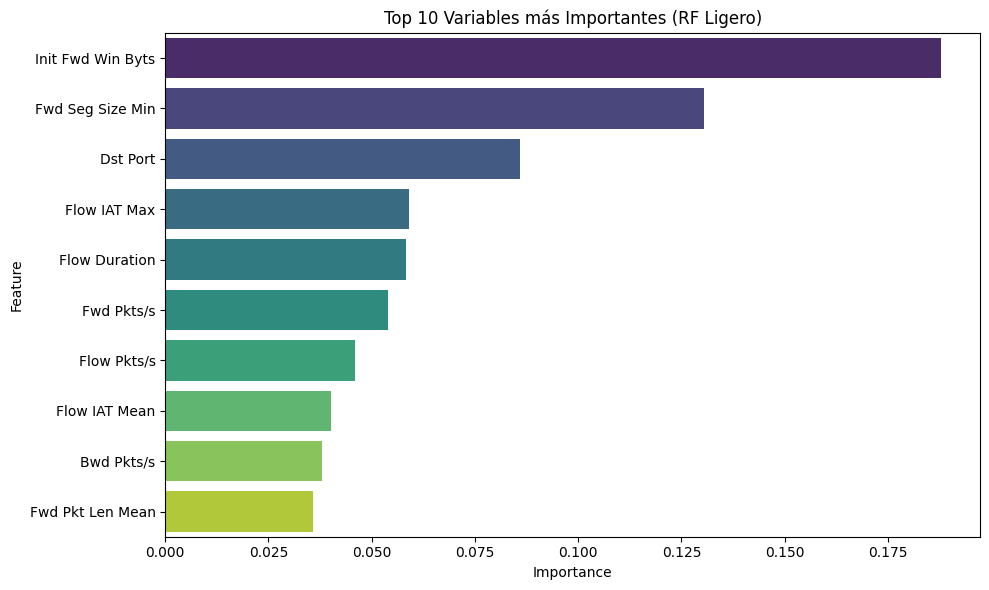

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("\n⭐ Extrayendo Top 10 Características...")
rf_model = model.stages[-1]
importancias = rf_model.featureImportances.toArray()

features_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importancias
}).sort_values(by='Importance', ascending=False).head(10)

print(features_df)

# Gráfico para tu informe
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title("Top 10 Variables más Importantes (RF Ligero)")
plt.tight_layout()
plt.show()